<a href="https://colab.research.google.com/github/shuv50/Cancer-Prediction-Genomes-AzureML/blob/main/Cancer_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import random
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, precision_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc

# Import data

https://genome.ucsc.edu/cgi-bin/hgTables?db=hg38&hgta_group=phenDis&hgta_track=gdcCancer&hgta_table=allCancer&hgta_doSchema=describe+table+schema

In [2]:
# Mount Google drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Import data
pan_cancer_df = pd.read_csv('/content/drive/MyDrive/Capstone/pan_cancer_data.csv')
pan_cancer_df.head(2)

,Unnamed: 0,"#""chrom""",chromStart,chromEnd,name,score,strand,thickStart,thickEnd,reserved,...,alcohol_intensity,bmi,years_smoked,height,gender,project_id,ethnicity,Tumor_Sample_Barcode,Matched_Norm_Sample_Barcode,case_id
0,0,chr1,1049635,1049636,C>T,1,.,1049635,1049636,"0,0,0",...,--,--,--,--,male,KICH,not hispanic or latino,TCGA-KN-8428-01A-11D-2310-10,TCGA-KN-8428-11A-01D-2311-10,455fd7d4-5ff4-423f-83ce-4630aef89bb7
1,1,chr1,1287957,1287958,G>A,1,.,1287957,1287958,"0,0,0",...,--,--,--,--,male,KICH,not hispanic or latino,TCGA-KO-8404-01A-11D-2310-10,TCGA-KO-8404-11A-01D-2311-10,11a33d4a-4839-468f-9d61-5630586ed978


## Shape of cancer data

In [4]:
# Shape
pan_cancer_df.shape

(1573235, 38)

## Dataframe info
In our dataset, there are originally 1,573,235 records with 37 columns (features). As we move forward, we'll perform data preprocessing and analytical tasks to ready it for our machine learning model.

In [5]:
# Dataframe info
pan_cancer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1573235 entries, 0 to 1573234
Data columns (total 38 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   Unnamed: 0                   1573235 non-null  int64  
 1   #"chrom"                     1573235 non-null  object 
 2   chromStart                   1573235 non-null  int64  
 3   chromEnd                     1573235 non-null  int64  
 4   name                         1573235 non-null  object 
 5   score                        1573235 non-null  int64  
 6   strand                       1573235 non-null  object 
 7   thickStart                   1573235 non-null  int64  
 8   thickEnd                     1573235 non-null  int64  
 9   reserved                     1573235 non-null  object 
 10  blockCount                   1573235 non-null  int64  
 11  blockSizes                   1573235 non-null  int64  
 12  chromStarts                  1573235 non-n

## Unique data

In [6]:
# Getting number of unique values in each column
result_df = pd.DataFrame(pan_cancer_df.nunique(), columns=['No. of Unique Values']).sort_values(by='No. of Unique Values')
print(result_df.to_string())

                             No. of Unique Values
strand                                          1
reserved                                        1
blockCount                                      1
chromStarts                                     1
Variant_Type                                    3
Variant_Classification                         18
project_id                                     20
#"chrom"                                       24
dbSNP_Val_Status                               43
score                                          47
alcohol_intensity                              47
sampleCount                                    47
alcohol_history                                90
blockSizes                                    112
freq                                          228
years_smoked                                  257
gender                                        323
ethnicity                                     694
cigarettes_per_day                           1058


# Data Preprocessing

During the data preprocessing phase, we will execute various data manipulation tasks, such as renaming columns to enhance feature clarity, filtering out unnecessary records, substituting dashes with null values, removing irrelevant columns, and identifying and rectifying missing data.

## Typecast columns

Save memory by typecasting numeric columns to int32

In [7]:
# Typecast numeric columns to int32 for memomry optimization
numeric_columns = pan_cancer_df.select_dtypes(exclude=[object, float]).columns
pan_cancer_df[numeric_columns] = pan_cancer_df[numeric_columns].astype('int32')

## Rename columns
Renaming columns to enhance feature clarity

In [8]:
# Columns to lowercase
pan_cancer_df.columns = pan_cancer_df.columns.str.lower()

# Rename columns
pan_cancer_df.rename(columns={'#"chrom"':'chrom', 'project_id':'cancer_type', 'variant_classification':'variant', 'matched_norm_sample_barcode':'barcode'}, inplace=True)

## Split records
Several records have higher sample counts, and their values are comma-separated. Therefore, it is necessary to split them into new rows.

In [9]:
# Specify the columns to split
columns_to_split = ['days_to_death', 'cigarettes_per_day', 'weight', 'alcohol_history', 'alcohol_intensity', 'bmi', 'years_smoked', 'height', 'gender', 'ethnicity', 'tumor_sample_barcode', 'barcode', 'case_id']

# Convert columns to strings and then split values
pan_cancer_df.loc[:, columns_to_split] = pan_cancer_df[columns_to_split].astype(str).apply(lambda x: x.str.split(','))

# Explode the specified columns and reset the index
pan_cancer_df = pan_cancer_df.explode(columns_to_split).reset_index(drop=True)
pan_cancer_df.shape

(1633864, 38)

## Replacing '--' with nulls

Many  records contain dashes -- , which represent null values. Therefore, we are substituting these dashes with NaN.

In [10]:
# Raw data has null values with dashes '--'
pan_cancer_df.head(1)

,unnamed: 0,chrom,chromstart,chromend,name,score,strand,thickstart,thickend,reserved,...,alcohol_intensity,bmi,years_smoked,height,gender,cancer_type,ethnicity,tumor_sample_barcode,barcode,case_id
0,0,chr1,1049635,1049636,C>T,1,.,1049635,1049636,"0,0,0",...,--,--,--,--,male,KICH,not hispanic or latino,TCGA-KN-8428-01A-11D-2310-10,TCGA-KN-8428-11A-01D-2311-10,455fd7d4-5ff4-423f-83ce-4630aef89bb7


In [11]:
# Replace '--' with nan
pan_cancer_df.replace('--', np.nan, inplace=True)
pan_cancer_df.head(1)

,unnamed: 0,chrom,chromstart,chromend,name,score,strand,thickstart,thickend,reserved,...,alcohol_intensity,bmi,years_smoked,height,gender,cancer_type,ethnicity,tumor_sample_barcode,barcode,case_id
0,0,chr1,1049635,1049636,C>T,1,.,1049635,1049636,"0,0,0",...,NaN,NaN,NaN,NaN,male,KICH,not hispanic or latino,TCGA-KN-8428-01A-11D-2310-10,TCGA-KN-8428-11A-01D-2311-10,455fd7d4-5ff4-423f-83ce-4630aef89bb7


## Check missing values

With the replacement of dashes by NaN, we can now assess the overall presence of null values in our dataset and determine appropriate strategies for handling them, such as imputations, removing insignificant columns, filling missing values, etc.

In [12]:
# Check missing values
pan_cancer_df.isnull().sum()

unnamed: 0                    0
chrom                         0
chromstart                    0
chromend                      0
name                          0
score                         0
strand                        0
thickstart                    0
thickend                      0
reserved                      0
blockcount                    0
blocksizes                    0
chromstarts                   0
samplecount                   0
freq                          0
hugo_symbol                   0
entrez_gene_id                0
variant                       0
variant_type                  0
reference_allele              0
tumor_seq_allele1             0
tumor_seq_allele2             0
dbsnp_rs                 478405
dbsnp_val_status        1415453
days_to_death           1224443
cigarettes_per_day      1416270
weight                   692630
alcohol_history         1560439
alcohol_intensity       1633864
bmi                      722636
years_smoked            1596361
height  

## Drop columns

Upon conducting research, it was determined that these columns hold no significance and do not affect the target column. Moving forward, we will also assess the correlation matrix to identify any further irrelevant columns and remove them accordingly.

In [13]:
# Drop based on null values
pan_cancer_df.drop(columns=['dbsnp_rs', 'dbsnp_val_status', 'days_to_death', 'cigarettes_per_day', 'weight', 'alcohol_history', 'alcohol_intensity', 'years_smoked', 'height', 'ethnicity', 'bmi'], inplace=True)

# Drop based on insignificance
pan_cancer_df.drop(columns=['case_id', 'reserved', 'blockcount', 'score', 'strand', 'chromstarts', 'samplecount', 'tumor_sample_barcode', 'entrez_gene_id'], inplace=True)


## Handle missing values

Given the significant influence of gender on physiological functions and, consequently, the prediction of cancer types, we computed the gender distribution and filled in missing values based on this distribution.

In [14]:
# Calculate the distribution of existing gender values
gender_distribution = pan_cancer_df['gender'].value_counts(normalize=True)

# Create a mask for null gender values
null_mask = pan_cancer_df['gender'].isnull()

# Fill null gender values with random genders based on the distribution
random_genders = np.random.choice(gender_distribution.index, size=null_mask.sum(), p=gender_distribution.values)
pan_cancer_df.loc[null_mask, 'gender'] = random_genders

# Check nulls after handling missing values
pan_cancer_df.isnull().sum()

unnamed: 0           0
chrom                0
chromstart           0
chromend             0
name                 0
thickstart           0
thickend             0
blocksizes           0
freq                 0
hugo_symbol          0
variant              0
variant_type         0
reference_allele     0
tumor_seq_allele1    0
tumor_seq_allele2    0
gender               0
cancer_type          0
barcode              0
dtype: int64

At the conclusion of the data preprocessing phase, we have successfully cleansed the data, and addressed missing values, rendering it prepared for analysis and integration with the machine learning model, with only a few additional transformations remaining.

# Data Analysis

## Total number of patients

The barcode is a unique identifier of each patient. After preprocessing we are left with 7223 unique patients only.

In [15]:
# Total patients
pan_cancer_df['barcode'].nunique()

7223

## Total cancer types

We have 20 different types of cancer - KICH, ACC, BLCA, BRCA, CESC, ESCA, KIRC, LAML, LGG, LIHC, OV, PAAD, PRAD, READ, TGCT, THCA, UCEC, LUAD, COAD, and SKCM.

In [16]:
# Total cancer types
pan_cancer_df['cancer_type'].nunique()

20



```
UCEC - Uterine Corpus Endometrial Carcinoma
SKCM - Skin Cutaneous Melanoma
BLCA - Bladder Urothelial Carcinoma         
COAD - Colon Adenocarcinoma                 
BRCA - Breast Invasive Carcinoma            
LUAD - Lung Adenocarcinoma                  
CESC - Cervical and Endocervical Cancer     
OV   - Ovarian Serous Cystadenocarcinoma    
READ - Rectum Adenocarcinoma                
LICH - Liver Hepatocellular Carcinoma       
ESCA - Esophageal Carcinoma                 
LGG  - Brain Lower Grade Glioma             
PAAD - Pancreatic Adenocarcinoma            
PRAD - Prostate Adenocarcinoma              
KIRK - Kidney Renal Clear Cell Carcinoma    
ACC  - Adrenocortical Carcinoma             
THCA - Thyroid Carcinoma                    
LAML - Acute Myeloid Leukemia               
TGCT - Testicular Germ Cell Tumors          
KICH - Kidney Chromophobe

```

## Data of each cancer type

Number of samples of each cancer type.

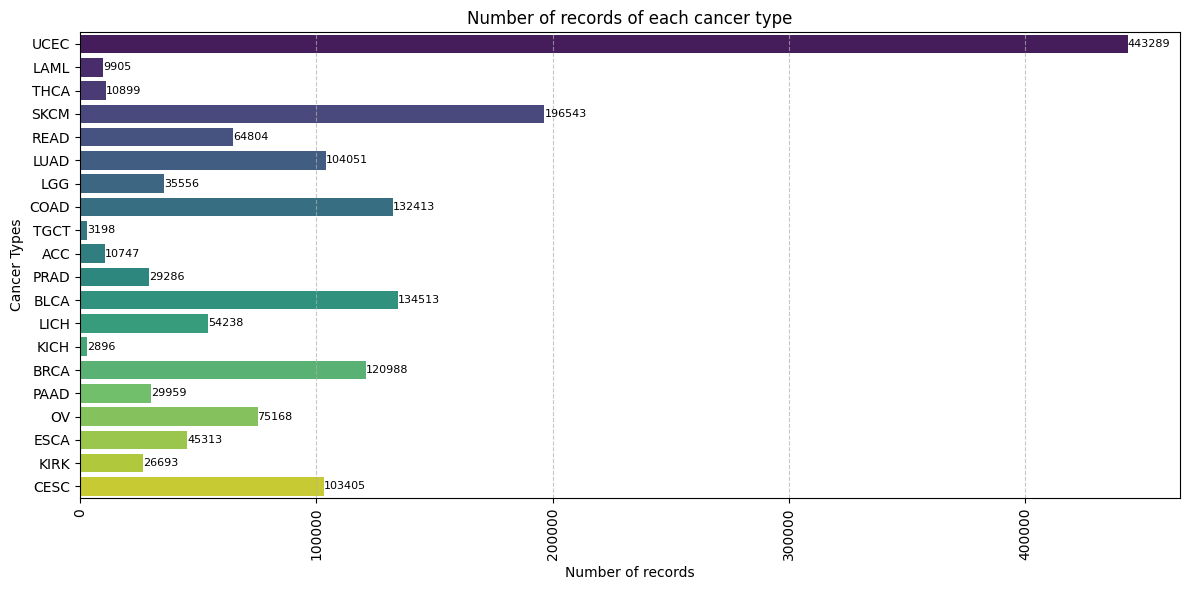

In [17]:
# Data of each cancer type
cancer_counts = pan_cancer_df['cancer_type'].value_counts().sample(frac=1, random_state=42)

# Graph of number of records of each cancer types
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=cancer_counts.values, y=cancer_counts.index, orient='h', palette='viridis')

# Label the bars with values
for i, v in enumerate(cancer_counts.values):
  ax.text(v + 0.2, i, str(v), color='black', va='center', fontsize=8)

# Plot graph
ax.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.xlabel('Number of records')
plt.ylabel('Cancer Types')
plt.title('Number of records of each cancer type')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Patients of each cancer type
Number of patients of each cancer type.

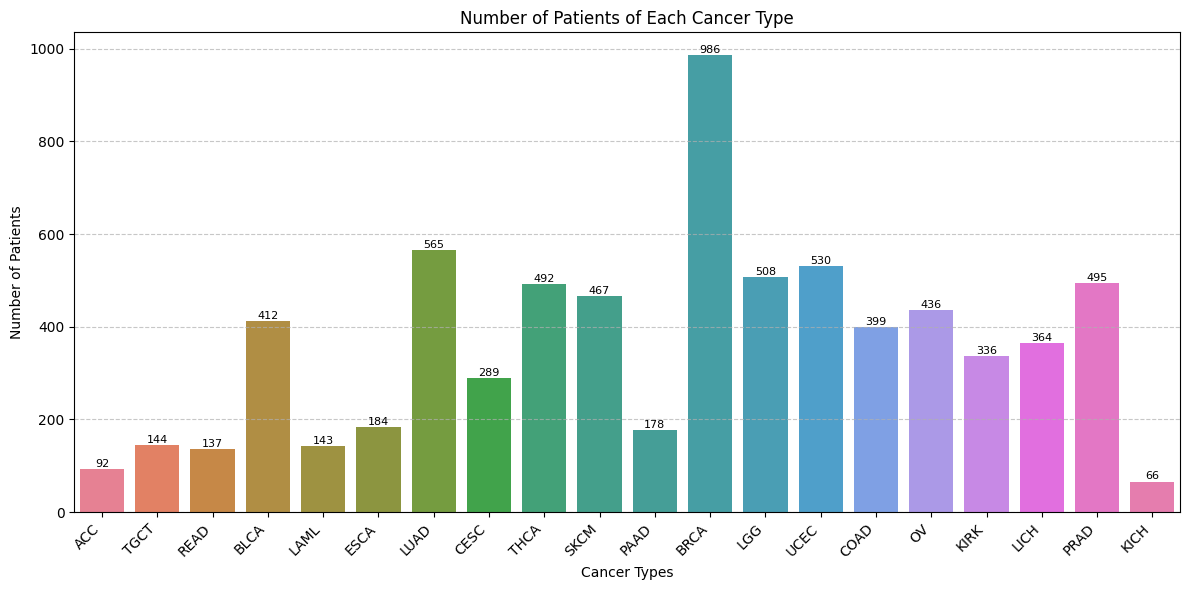

In [18]:
# Patients of each cancer type
cancer_patient_counts = pan_cancer_df.groupby('cancer_type')['barcode'].nunique().sample(frac=1, random_state=42)

# Graph of number of patients of each cancer types
plt.figure(figsize=(12, 6))
sns.barplot(x=cancer_patient_counts.index, y=cancer_patient_counts.values, palette='husl')


# Label each bar with its value
for i, value in enumerate(cancer_patient_counts.values):
  plt.text(i, value + 0.1, str(value), ha='center', va='bottom', fontsize=8)

# Plot graph
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlabel('Cancer Types')
plt.ylabel('Number of Patients')
plt.title('Number of Patients of Each Cancer Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Total variants
The total number of variants of cancer present in the dataset.

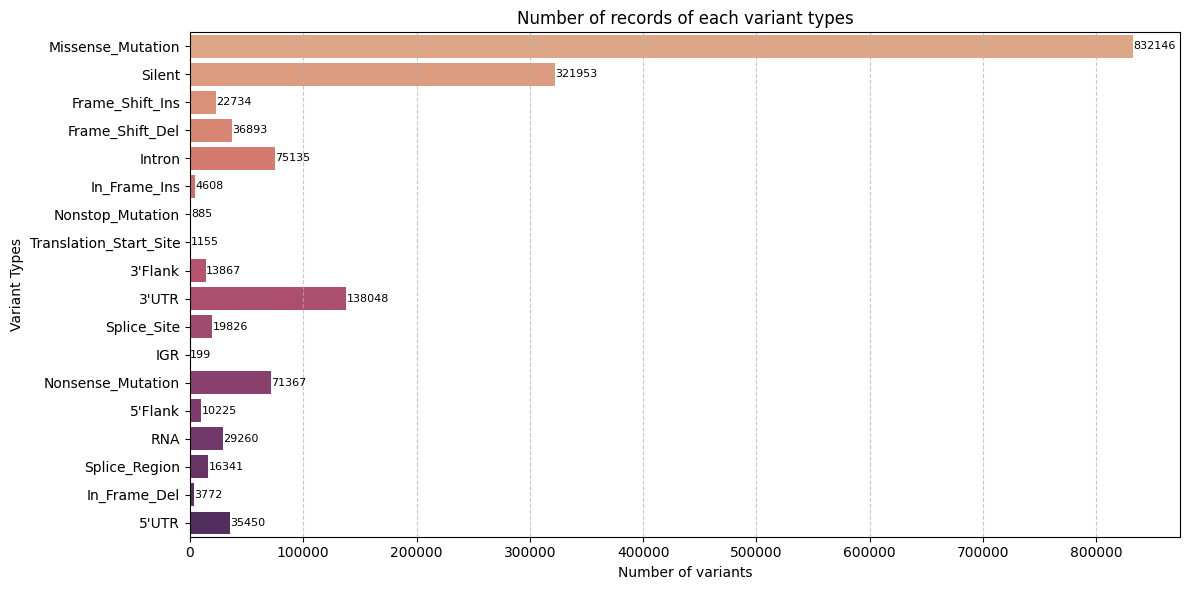

In [19]:
# Total variants
variant_counts = pan_cancer_df['variant'].value_counts().sample(frac=1, random_state=42)

# Graph of variant counts
plt.figure(figsize=(12, 6))
sns.barplot(x=variant_counts.values, y=variant_counts.index, orient='h', palette='flare')

# Label each bar with its value
for i, value in enumerate(variant_counts.values):
  plt.text(value + 0.1, i, str(value), ha='left', va='center', fontsize=8)

# Plot graph
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xlabel('Number of variants')
plt.ylabel('Variant Types')
plt.title('Number of records of each variant types')
plt.tight_layout()
plt.show()

## Different chroms
Different types of chroms in the cancer dataset.

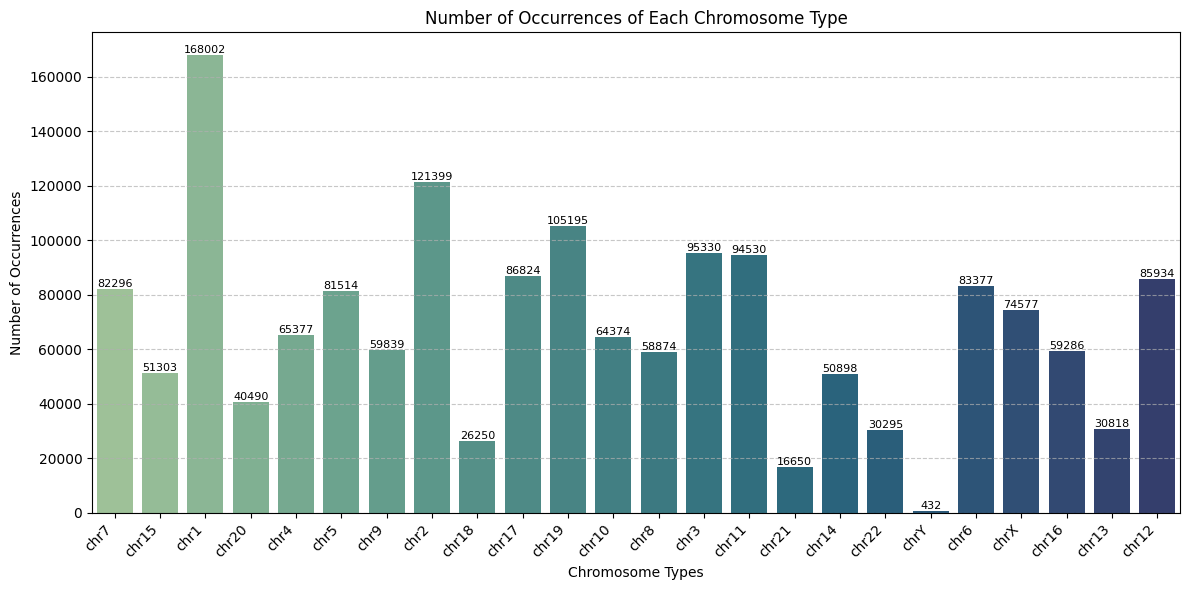

In [20]:
# Chrom counts
chrom_counts = pan_cancer_df['chrom'].value_counts().sample(frac=1, random_state=42)

# Graph of number of patients of each cancer types
plt.figure(figsize=(12, 6))
sns.barplot(x=chrom_counts.index, y=chrom_counts.values, palette='crest')

# Label each bar with its value
for i, value in enumerate(chrom_counts.values):
  plt.text(i, value + 0.1, str(value), ha='center', va='bottom', fontsize=8)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlabel('Chromosome Types')
plt.ylabel('Number of Occurrences')
plt.title('Number of Occurrences of Each Chromosome Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Variant type counts

Different variant types available.

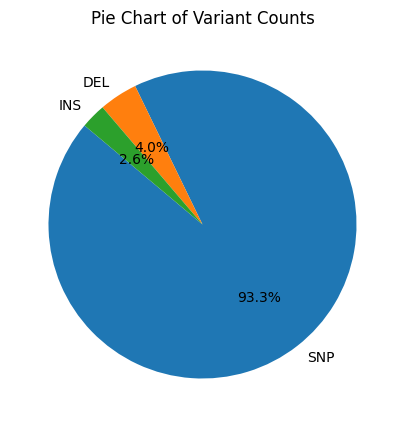

In [21]:
# Variant type counts
variant_type_counts = pan_cancer_df['variant_type'].value_counts()

# Plot graph
plt.figure(figsize=(5, 5))
plt.pie(variant_type_counts, labels=variant_type_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Pie Chart of Variant Counts')
plt.show()

## Gender distribution

Gender distribution of the cancer data.

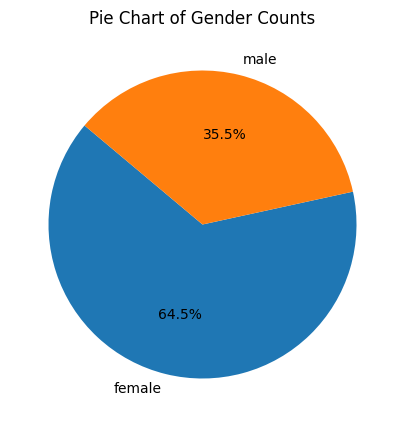

In [22]:
# Gender distribution
gender_counts = pan_cancer_df['gender'].value_counts()

# Plot graph
plt.figure(figsize=(5,5))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Pie Chart of Gender Counts')
plt.show()

# Label encoding

Label encoding is a technique used in machine learning and data preprocessing to convert categorical data, specifically nominal or ordinal data, into numerical format. Categorical data consists of values that represent categories or labels rather than numerical quantities. Label encoding assigns a unique integer to each category, effectively converting them into numerical values. This can be useful because many machine learning algorithms require numerical input.

In [23]:
# Drop 'barcode' column
pan_cancer_df.drop(columns=['barcode'], inplace=True)

# Check data before encoding
pan_cancer_df.head()

,unnamed: 0,chrom,chromstart,chromend,name,thickstart,thickend,blocksizes,freq,hugo_symbol,variant,variant_type,reference_allele,tumor_seq_allele1,tumor_seq_allele2,gender,cancer_type
0,0,chr1,1049635,1049636,C>T,1049635,1049636,1,0.015152,AGRN,Missense_Mutation,SNP,C,C,T,male,KICH
1,1,chr1,1287957,1287958,G>A,1287957,1287958,1,0.015152,SCNN1D,Missense_Mutation,SNP,G,G,A,male,KICH
2,2,chr1,1332660,1332661,C>T,1332660,1332661,1,0.015152,TAS1R3,Missense_Mutation,SNP,C,C,T,male,KICH
3,3,chr1,1440273,1440274,G>A,1440273,1440274,1,0.015152,VWA1,3'UTR,SNP,G,G,A,female,KICH
4,4,chr1,1440294,1440295,C>T,1440294,1440295,1,0.015152,VWA1,3'UTR,SNP,C,C,T,male,KICH


In [24]:
# Label encoding
le = LabelEncoder()

# Iterate through columns and apply label encoding
for column in pan_cancer_df.columns:
    if pan_cancer_df[column].dtype == 'object':
        pan_cancer_df[column] = le.fit_transform(pan_cancer_df[column])

class_labels = {i: label for i, label in enumerate(le.classes_)}
pan_cancer_df.head()

,unnamed: 0,chrom,chromstart,chromend,name,thickstart,thickend,blocksizes,freq,hugo_symbol,variant,variant_type,reference_allele,tumor_seq_allele1,tumor_seq_allele2,gender,cancer_type
0,0,0,1049635,1049636,5,1049635,1049636,1,0.015152,669,10,2,2174,2174,11599,1,6
1,1,0,1287957,1287958,6,1287957,1287958,1,0.015152,16596,10,2,4760,4760,1,1,6
2,2,0,1332660,1332661,5,1332660,1332661,1,0.015152,18597,10,2,2174,2174,11599,1,6
3,3,0,1440273,1440274,6,1440273,1440274,1,0.015152,20633,1,2,4760,4760,1,0,6
4,4,0,1440294,1440295,5,1440294,1440295,1,0.015152,20633,1,2,2174,2174,11599,1,6


# Correlation matrix

A correlation matrix is a table that shows the correlation coefficients between many variables. Each cell in the table displays the correlation between two variables.

In [25]:
# Correlation of 'cancer_type' with all features
pan_cancer_df.corr()['cancer_type']

unnamed: 0           0.663572
chrom                0.008899
chromstart           0.005873
chromend             0.005873
name                -0.010679
thickstart           0.005873
thickend             0.005873
blocksizes          -0.032801
freq                -0.001255
hugo_symbol         -0.000988
variant             -0.031719
variant_type         0.023106
reference_allele    -0.001262
tumor_seq_allele1   -0.001262
tumor_seq_allele2   -0.004379
gender              -0.174405
cancer_type          1.000000
Name: cancer_type, dtype: float64

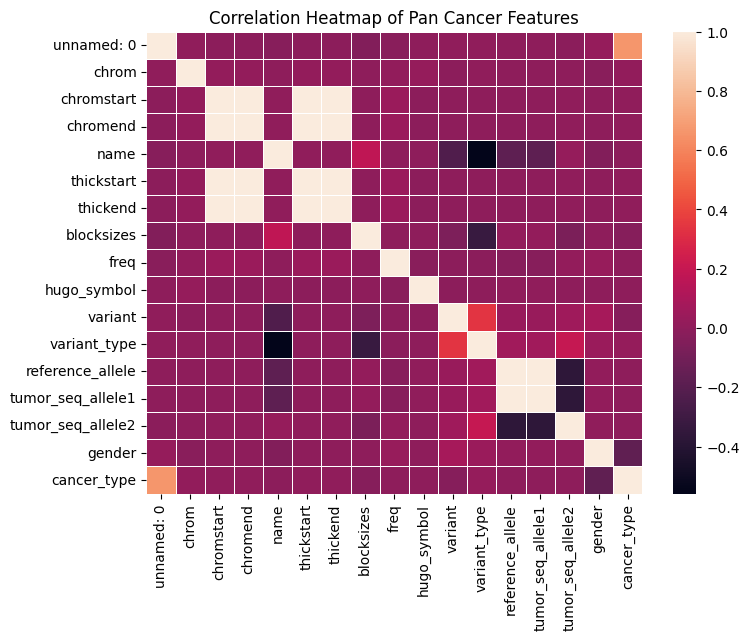

In [26]:
# Create the heatmap using the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(pan_cancer_df.corr(), linewidths=0.5)
plt.title('Correlation Heatmap of Pan Cancer Features')
plt.show()

# Feature selection

In [27]:
# Select required features
pan_cancer_df = pan_cancer_df[['chrom', 'chromstart', 'chromend', 'name', 'thickstart', 'thickend', 'blocksizes', 'freq', 'variant', 'variant_type', 'tumor_seq_allele1', 'tumor_seq_allele2', 'gender', 'cancer_type']]
pan_cancer_df.head()

,chrom,chromstart,chromend,name,thickstart,thickend,blocksizes,freq,variant,variant_type,tumor_seq_allele1,tumor_seq_allele2,gender,cancer_type
0,0,1049635,1049636,5,1049635,1049636,1,0.015152,10,2,2174,11599,1,6
1,0,1287957,1287958,6,1287957,1287958,1,0.015152,10,2,4760,1,1,6
2,0,1332660,1332661,5,1332660,1332661,1,0.015152,10,2,2174,11599,1,6
3,0,1440273,1440274,6,1440273,1440274,1,0.015152,1,2,4760,1,0,6
4,0,1440294,1440295,5,1440294,1440295,1,0.015152,1,2,2174,11599,1,6


# Split data

With all the data preprocessing steps now finalized, we are prepared to divide the data into dependent and independent variables, as well as create training and test sets for our machine learning model.

## Independent/Dependent variables in training set

During the training of a machine learning model, the algorithm learns patterns from the independent dataset and tries to generalize those patterns to make predictions on new data (the dependent dataset).

In [28]:
# Split data into dependent/independent variables
X = pan_cancer_df.iloc[:, :-1].values
y = pan_cancer_df.iloc[:, -1].values

## Test/Train split

We are splitting the data for each cancer type, dedicating 80% for training and 20% for testing. This approach ensures that our model is trained on a diverse range of cancer types, enhancing its ability to deliver more accurate predictions.

In [29]:
# Test/Train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature scaling

Feature scaling is a preprocessing step in machine learning that involves normalizing or standardizing the features of a dataset. The goal of feature scaling is to bring all features to a similar scale or range, which can be important for certain machine learning algorithms to perform effectively.



In [30]:
# Scale dataset
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Train model

Now that we have completed preprocessing the data, including label encoding, feature selection, test/train split, and feature scaling, we are ready to move on to the next step - training our model with the prepared dataset and making predictions.

## Random Forest Classifier

This is our base model for classification.

A Random Forest Classifier is an ensemble learning method that belongs to the family of decision tree-based models. It is particularly powerful for both classification and regression tasks. The Random Forest algorithm constructs multiple decision trees during training and outputs the mode (classification) or mean prediction (regression) of the individual trees.

In [31]:
# Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=10, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=42)

## XGBoost Classifier

XGBoost (Extreme Gradient Boosting) is a powerful and efficient machine learning algorithm that belongs to the family of gradient boosting algorithms. It is widely used for both classification and regression tasks and has gained popularity for its high performance and scalability.



In [32]:
# Cross validation
def cross_val(model, X_train, X_test, y_train, n_splits=5):
  oofs = np.zeros(len(X_train))
  preds = np.zeros(len(X_test))

  target_col = pd.DataFrame(data=y_train)

  folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
  stratified_target = pd.qcut(y_train, 10, labels=False, duplicates='drop')

  for index, (trn_idx, val_idx) in enumerate(folds.split(X_train, stratified_target)):
    print(f'\n================================ Fold {index + 1} ===================================')

    cv_X_train, cv_y_train = X_train[trn_idx], target_col.iloc[trn_idx]
    cv_X_val, cv_y_val = X_train[val_idx], target_col.iloc[val_idx]

    model.fit(cv_X_train, cv_y_train)

    val_preds = model.predict(cv_X_val)
    test_preds = model.predict(X_test)

    error = precision_score(cv_y_val, val_preds, average='macro')
    print(f'Precision is : {error}')

    oofs[val_idx] = val_preds
    preds += test_preds/n_splits

  total_error = precision_score(target_col, oofs, average='macro')
  print(f'\n Precision is {total_error}')

  return oofs, preds

Cross-validation is a statistical technique used in machine learning to assess the performance and generalization ability of a predictive model. It involves dividing a dataset into multiple subsets or folds, training the model on some of these folds, and then evaluating its performance on the remaining folds. The process is repeated multiple times, each time using a different subset as the test set and the remaining data as the training set. The key idea is to use different parts of the dataset for both training and testing to obtain a more robust estimate of the model's performance.

In [33]:
# XGBoost Classifier
xgb_classifier = xgb.XGBClassifier(objective="multi:softmax", num_class=20, n_estimators=10, random_state=42)

# Cross validation
xgb_oofs, xgb_pred = cross_val(xgb_classifier, X_train, X_test, y_train, 5)


================================ Fold 1 ===================================
Precision is : 0.9976954835910833

================================ Fold 2 ===================================
Precision is : 0.9975281741049192

================================ Fold 3 ===================================
Precision is : 0.9975182122377946

================================ Fold 4 ===================================
Precision is : 0.997379201922928

================================ Fold 5 ===================================
Precision is : 0.9976331788762401

 Precision is 0.9975549536660667


# Predict result

Upon completing the training of our model, we are now equipped to employ machine learning algorithms for predicting cancer types. These algorithms have been trained on our dataset, enabling them to make informed predictions based on the learned patterns and relationships within the data.

In [34]:
# Random Forest
rf_pred = rf_classifier.predict(X_test)

# XGBoost
xgb_pred = list(map(int, xgb_pred))

# Evaluate model

## Accuracy

In [35]:
# Random Forest
rf_accuracy = accuracy_score(y_test, rf_pred)
print(f"Random Forest Classifier Accuracy: {rf_accuracy:.4f}")

# XGBoost
xgb_accuracy = accuracy_score(y_test, xgb_pred)
print(f"XGBoost Classifier Accuracy: {xgb_accuracy:.4f}")

Random Forest Classifier Accuracy: 0.9834
XGBoost Classifier Accuracy: 0.9975


## Precision

In [36]:
# Random Forest
rf_precision = precision_score(rf_pred, y_test, average='macro')
print(f"Random Forest Classifier Precision: {rf_precision:.4f}")

# XGBoost
xgb_precision = precision_score(xgb_pred, y_test, average='macro')
print(f"Random Forest Classifier Precision: {xgb_precision:.4f}")

Random Forest Classifier Precision: 0.8909
Random Forest Classifier Precision: 0.9964


## Classification report

In [37]:
# XGBoost Classifier
xgb_report = classification_report(y_test, xgb_pred)
print("\nXGBoost Classifier Classification Report:\n")
print(xgb_report)


XGBoost Classifier Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2149
           1       1.00      1.00      1.00     26903
           2       1.00      1.00      1.00     24198
           3       1.00      1.00      1.00     20681
           4       1.00      0.99      0.99     26483
           5       1.00      0.99      0.99      9062
           6       0.92      1.00      0.96       579
           7       1.00      1.00      1.00      5338
           8       0.99      0.99      0.99      1981
           9       1.00      1.00      1.00      7111
          10       1.00      1.00      1.00     10848
          11       1.00      1.00      1.00     20810
          12       1.00      1.00      1.00     15034
          13       1.00      1.00      1.00      5992
          14       1.00      1.00      1.00      5857
          15       1.00      1.00      1.00     12961
          16       1.00      1.00    

## F1 score

In [38]:
# Calculate F1 score
xgb_f1 = f1_score(y_test, xgb_pred, average='macro')
print(f"XGBoost Classifier F1 Score: {xgb_f1:.4f}")

XGBoost Classifier F1 Score: 0.9946


## Confusion matrix

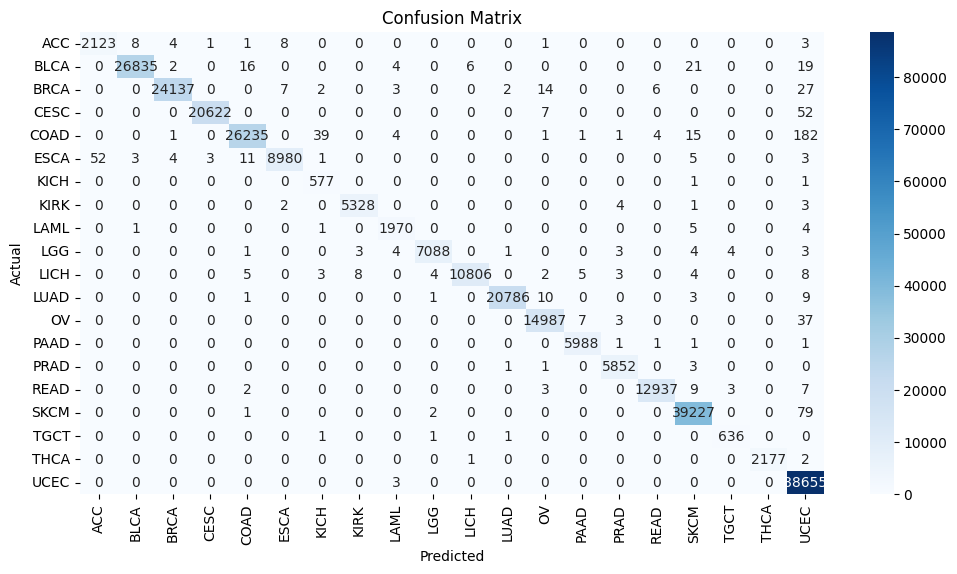

In [39]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, xgb_pred)

# Create a Seaborn heatmap for the confusion matrix
plt.figure(figsize=(12, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels.values(), yticklabels=class_labels.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Precision-Recall curve

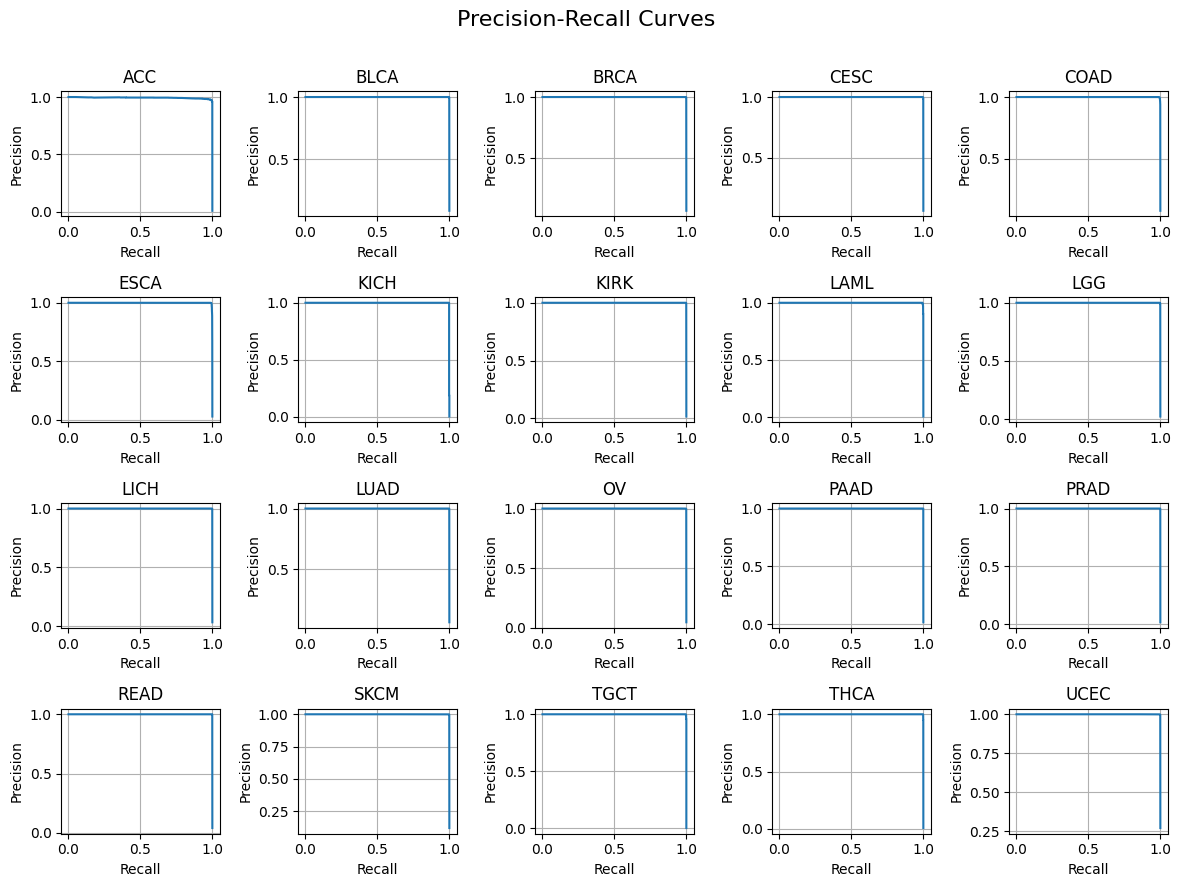

In [40]:
# Binarize labels
y_test_bin = label_binarize(y_test, classes=np.arange(20))

# Classes
class_names = list(class_labels.values())

# Plot curve
fig, axs = plt.subplots(4, 5, figsize=(12, 9))
fig.suptitle("Precision-Recall Curves", fontsize=16)
axs = axs.flatten()

for class_label in range(20):
  # Calculate precision/recall for current class
  xgb_precision, xgb_recall, _ = precision_recall_curve(y_test_bin[:, class_label], xgb_classifier.predict_proba(X_test)[:, class_label])

  # Plot current curve
  axs[class_label].plot(xgb_recall, xgb_precision) #, label=f"{class_names[class_label]}", color='r')
  axs[class_label].set_xlabel("Recall")
  axs[class_label].set_ylabel("Precision")
  axs[class_label].set_title(f"{class_names[class_label]}")
  #axs[class_label].legend(loc='best')
  axs[class_label].grid()

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

## AUC/ROC curve

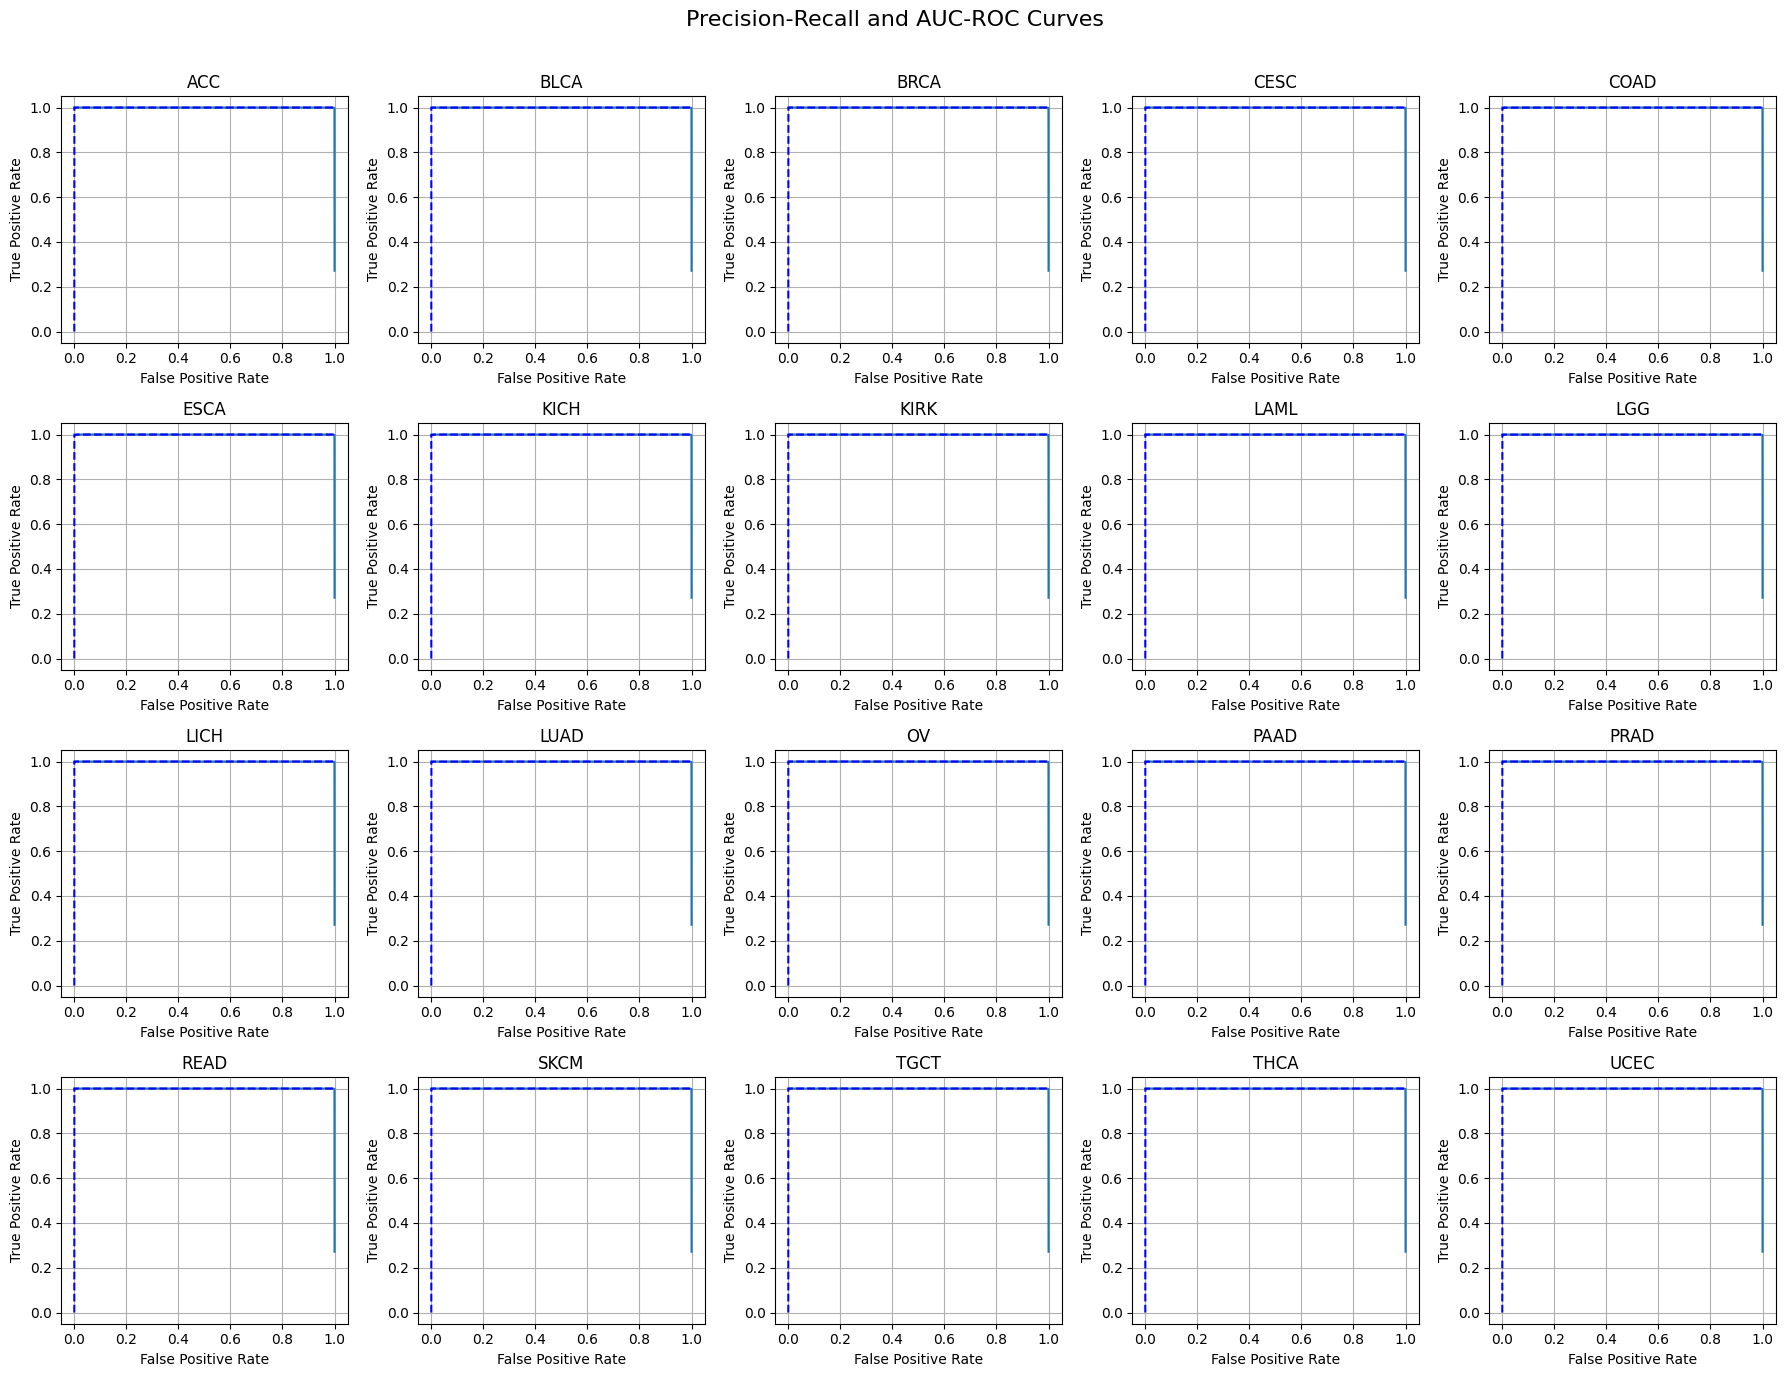

In [41]:
# Plot curve
fig, axs = plt.subplots(4, 5, figsize=(18, 14))
fig.suptitle("Precision-Recall and AUC-ROC Curves", fontsize=16)
axs = axs.flatten()

for class_label in range(20):
    # Calculate ROC curve for current class
    fpr, tpr, _ = roc_curve(y_test_bin[:, class_label], xgb_classifier.predict_proba(X_test)[:, class_label])

    # Calculate AUC for ROC curve
    roc_auc = auc(fpr, tpr)

    # Plot Precision-Recall curve for the current class
    axs[class_label].plot(xgb_recall, xgb_precision) #, label=f"PR Curve ({class_names[class_label]})", color='r')
    axs[class_label].plot(fpr, tpr, label=f"AUC-ROC ({class_names[class_label]}) = {roc_auc:.2f}", color='b', linestyle='--')
    axs[class_label].set_xlabel("False Positive Rate")
    axs[class_label].set_ylabel("True Positive Rate")
    axs[class_label].set_title(f"{class_names[class_label]}")
    #axs[class_label].legend(loc='best')
    axs[class_label].grid()

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# Conclusion

# References

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9499478/

https://genome.ucsc.edu/cgi-bin/hgTables?db=hg38&hgta_group=phenDis&hgta_track=gdcCancer&hgta_table=allCancer&hgta_doSchema=describe+table+schema